In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.applications import vgg19

In [3]:
np.random.seed(123456780)

In [4]:
# This prevents a nasty bug: using preprocess_input within a Dataset
# throws an error due to a global variable not being initialized 
# in the tensor context
_ = vgg19.preprocess_input(tf.zeros((1, 224, 224, 3)))

# Sneaker Type Classification
## Classifying series of Jordan basketball sneakers

Dataset location: https://www.kaggle.com/sebastiaanjohn/sneakers

In [5]:
BASE_DIR = "jordans"
DATA_DIR = "data_descriptors"

TRAIN_PCT = 0.8
VAL_PCT = 0.1
TEST_PCT = 0.1

IMAGE_SIZE = (224, 224)
IMAGE_SIZE_INPUT = (224, 224, 3)

In [6]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [7]:
model_filenames = {}
for model_dir in os.listdir(BASE_DIR):
    model_dir_parts = model_dir.split(" ", maxsplit = 2)
    model_name = f"{model_dir_parts[0]} {model_dir_parts[1]}"
    print(model_dir)
    
    full_model_dir = os.path.join(BASE_DIR, model_dir)
    files_in_model_dir = os.listdir(full_model_dir)
    files_in_model_dir = [os.path.join(full_model_dir, file) for file in files_in_model_dir]
    files_in_model_dir = [os.path.abspath(file) for file in files_in_model_dir]
    
    if model_name not in model_filenames:
        model_filenames[model_name] = []
    
    model_filenames[model_name].extend(files_in_model_dir)

Jordan 1 Low Black Toe
Jordan 1 Low Gold Toe
Jordan 1 Low Lakers Top 3
Jordan 1 Low Royal Toe
Jordan 1 Low Sail University Gold Black
Jordan 1 Low SB Midnight Navy
Jordan 1 Low SB UNC
Jordan 1 Low Shattered Backboard
Jordan 1 Low White Black Mystic Green
Jordan 1 Low White Gum Hyper Pink
Jordan 1 Mid All Over Logos
Jordan 1 Mid Alternate Think 16
Jordan 1 Mid Atmosphere Grey Pale Ivory (W)
Jordan 1 Mid Black Cyber Mystic Green (GS)
Jordan 1 Mid Black Dark Concord
Jordan 1 Mid Black Particle Grey Gym Red
Jordan 1 Mid Bred Multi-Color
Jordan 1 Mid Coral Gold
Jordan 1 Mid Crimson Tint
Jordan 1 Mid Gunsmoke Volt
Jordan 1 Mid Gym Red Black
Jordan 1 Mid Infrared 23
Jordan 1 Mid Iridescent Black (W)
Jordan 1 Mid Lakers Top 3
Jordan 1 Mid Monsoon Blue (GS)
Jordan 1 Mid Patent Black White Gold
Jordan 1 Mid Pine Green
Jordan 1 Mid Quai54 (2019)
Jordan 1 Mid Reverse Black Toe (W)
Jordan 1 Mid SE Lakers
Jordan 1 Mid Team Orange Black
Jordan 1 Mid Top 3
Jordan 1 Mid Triple Black (2018)
Jordan 1 Mid

In [8]:
model_filenames_df = pd.DataFrame({"filename": [], "model": []})

for (model_name, filenames) in model_filenames.items():
    records = [{"filename": filename, "model": model_name} for filename in filenames]
    model_filenames_df = model_filenames_df.append(records)

In [9]:
model_filenames_df

,filename,model
0,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
1,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
2,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
3,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
4,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
...,...,...
128,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 9
129,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 9
130,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 9
131,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 9


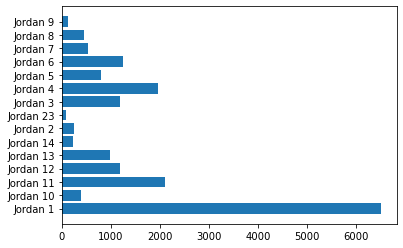

In [10]:
groups_by_num_images = model_filenames_df.groupby("model").size()
plt.barh(groups_by_num_images.index, groups_by_num_images)
plt.show()

In [11]:
groups_by_num_images

model
Jordan 1     6503
Jordan 10     382
Jordan 11    2095
Jordan 12    1178
Jordan 13     975
Jordan 14     236
Jordan 2      252
Jordan 23      76
Jordan 3     1178
Jordan 4     1966
Jordan 5      796
Jordan 6     1242
Jordan 7      542
Jordan 8      461
Jordan 9      133
dtype: int64

In [12]:
filenames_to_test = model_filenames_df.sample(10)

In [13]:
def display_images(image_descriptors):
    for filename, model_class in image_descriptors.values:
        try:
            image = imread(filename)
            plt.imshow(image)
            plt.title(model_class)
            plt.show()
        except:
            print(f"Could not read {filename}")
            continue

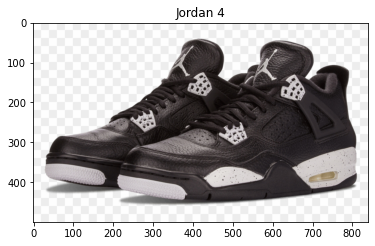

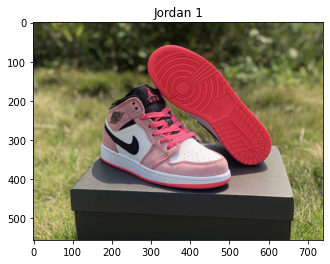

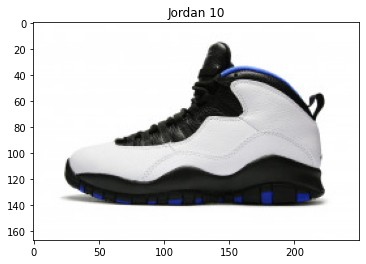

Could not read D:\SoftUni\deep-learning\Dec-2020\09. Exam-Preparation-End-To-End-Project\jordans\Jordan 1 Low Black Toe\15.jpg


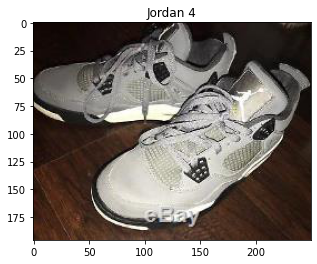

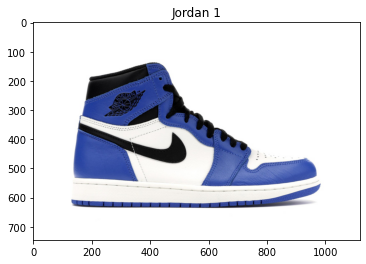

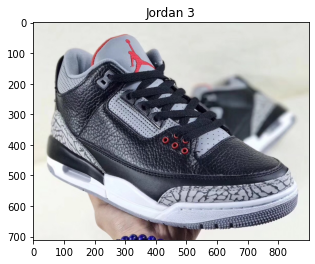

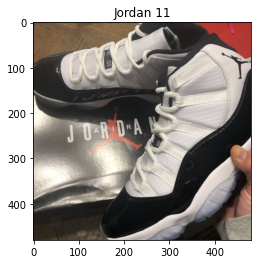

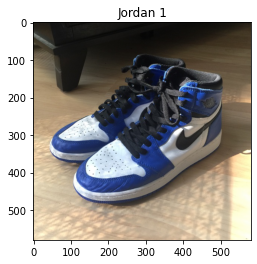

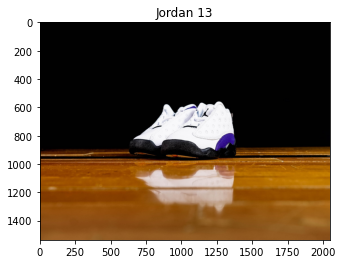

In [14]:
display_images(filenames_to_test)

In [15]:
models_to_select = ["Jordan 1", "Jordan 4", "Jordan 6", "Jordan 11"]
models_map = {
    "Jordan 1": 0,
    "Jordan 4": 1,
    "Jordan 6": 2,
    "Jordan 11": 3,
}

max_num_samples_to_select = 1200

In [16]:
selected_model_filenames_df = model_filenames_df[model_filenames_df.model.isin(models_to_select)]

In [17]:
selected_model_filenames_df

,filename,model
0,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
1,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
2,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
3,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
4,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 1
...,...,...
1237,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 6
1238,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 6
1239,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 6
1240,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,Jordan 6


In [18]:
def get_readable_files(filenames):
    readable_files = []
    for filename in filenames:
        try:
            imread(filename)
            readable_files.append(True)
        except:
            readable_files.append(False)
            continue
    return readable_files

In [19]:
readable_files = get_readable_files(selected_model_filenames_df.filename.values)

In [20]:
selected_model_filenames_df["is_readable"] = readable_files
selected_model_filenames_df.is_readable = pd.Series(selected_model_filenames_df.is_readable)

C:\Users\Yordan\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Yordan\Anaconda3\envs\tf2\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
selected_model_filenames_df = selected_model_filenames_df[selected_model_filenames_df.is_readable]

In [22]:
selected_model_filenames_balanced = pd.DataFrame()
for (model_name, group_filenames) in selected_model_filenames_df.groupby("model"):
    readable_filenames = group_filenames[group_filenames.is_readable]
    selected_model_filenames_balanced = selected_model_filenames_balanced.append(
        readable_filenames.sample(max_num_samples_to_select, replace = False))

In [23]:
selected_model_filenames_balanced = selected_model_filenames_balanced.drop("is_readable", axis = 1)
selected_model_filenames_balanced.to_csv(os.path.join(DATA_DIR, "filenames.csv"), index = False)

In [24]:
def split_data(dataset):
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for (model_name, group_filenames) in dataset.groupby("model"):
        group_filenames = group_filenames.sample(len(group_filenames))

        train_data_end_index = int(len(group_filenames) * TRAIN_PCT)
        val_data_end_index = train_data_end_index + int(len(group_filenames) * VAL_PCT)

        train_data_in_group = group_filenames[:train_data_end_index]
        val_data_in_group = group_filenames[train_data_end_index:val_data_end_index]
        test_data_in_group = group_filenames[val_data_end_index:]

        train_data = train_data.append(train_data_in_group)
        val_data = val_data.append(val_data_in_group)    
        test_data = test_data.append(test_data_in_group)
        
    return (train_data, val_data, test_data)

In [25]:
train_data, val_data, test_data = split_data(selected_model_filenames_balanced)

In [26]:
train_data.to_csv(os.path.join(DATA_DIR, "train.csv"), index = False)
val_data.to_csv(os.path.join(DATA_DIR, "val.csv"), index = False)
test_data.to_csv(os.path.join(DATA_DIR, "test.csv"), index = False)

In [27]:
train_data.groupby("model").size()

model
Jordan 1     960
Jordan 11    960
Jordan 4     960
Jordan 6     960
dtype: int64

In [28]:
train_data_sample = train_data.sample(10)

In [29]:
train_data_sample.model = train_data_sample.model.map(models_map)

In [30]:
train_data_sample

,filename,model
53,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,1
70,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,3
727,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,3
3192,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,0
695,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,3
349,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,3
143,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,2
1139,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,2
2404,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,0
143,D:\SoftUni\deep-learning\Dec-2020\09. Exam-Pre...,3


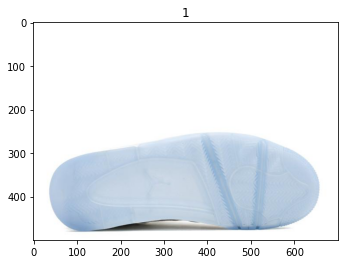

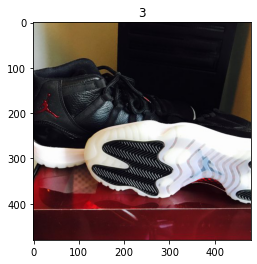

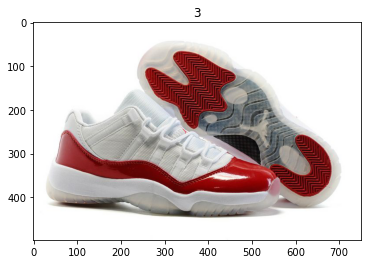

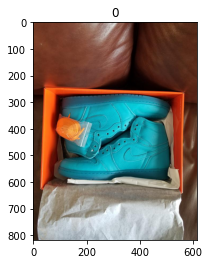

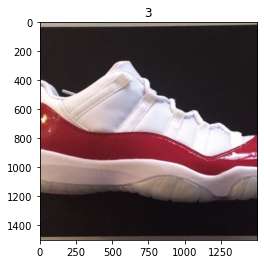

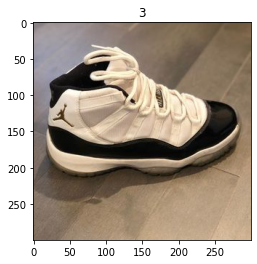

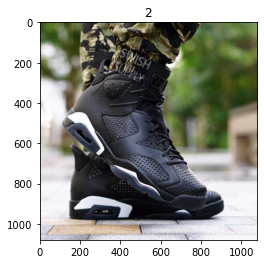

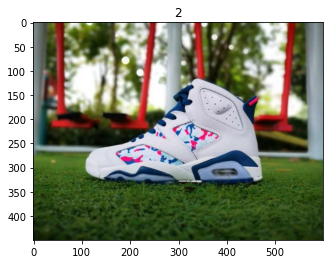

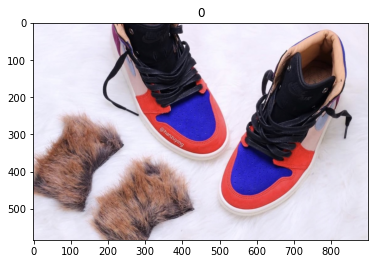

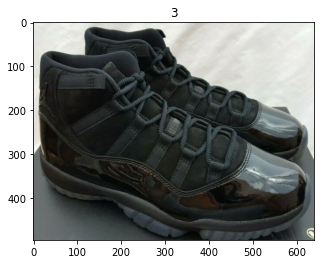

In [31]:
display_images(train_data_sample)

In [32]:
def read_image(filename, model):
    file = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(file)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 256.0
    return (image, model)

In [33]:
poc_dataset = tf.data.Dataset.from_tensor_slices(
    (train_data_sample.filename.values, train_data_sample.model.values))

In [34]:
poc_dataset = poc_dataset.map(read_image)
poc_dataset = poc_dataset.batch(10)
poc_dataset = poc_dataset.repeat()

In [35]:
tf.keras.backend.clear_session()

In [36]:
cnn_model = Sequential([
    Input(IMAGE_SIZE_INPUT),
    Conv2D(64, kernel_size = (3, 3), padding = "same", activation = "relu"),
    MaxPool2D(),
    Conv2D(32, kernel_size = (3, 3), padding = "same", activation = "relu"),
    MaxPool2D(),
    Conv2D(16, kernel_size = (3, 3), padding = "same", activation = "relu"),
    Flatten(),
    Dense(16, activation = "relu"),
    Dropout(0.25),
    Dense(len(models_to_select), activation = "softmax")
])

In [37]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                8

In [38]:
cnn_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [39]:
cnn_model.fit(poc_dataset, epochs = 30, steps_per_epoch = 1, callbacks = [TensorBoard()])

Train for 1 steps
Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 1.3618 - accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 0s 457ms/step - loss: 2.2181 - accuracy: 0.4000
Epoch 3/30
1/1 [==============================] - 0s 140ms/step - loss: 1.4706 - accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 0s 140ms/step - loss: 1.2072 - accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 0s 140ms/step - loss: 1.1645 - accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 0s 141ms/step - loss: 1.0351 - accuracy: 0.7000
Epoch 7/30
1/1 [==============================] - 0s 139ms/step - loss: 0.9255 - accuracy: 0.7000
Epoch 8/30
1/1 [==============================] - 0s 140ms/step - loss: 0.8678 - accuracy: 0.7000
Epoch 9/30
1/1 [==============================] - 0s 131ms/step - loss: 0.7284 - accuracy: 0.7000
Epoch 10/30
1/1 [==============================] - 0s 141ms/step - loss: 0.5803 - accuracy: 0.8000
Epoc

In [40]:
cnn_model.evaluate(poc_dataset, steps = 1)

1/1 [==============================] - 0s 278ms/step - loss: 0.2826 - accuracy: 0.8000


[0.28263336420059204, 0.8]

In [41]:
vgg_model = vgg19.VGG19()

In [42]:
def read_image_vgg(filename, model):
    file = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(file)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = vgg19.preprocess_input(image)
    return (image, model)

In [43]:
vgg_dataset = tf.data.Dataset.from_tensor_slices(
    (train_data_sample.filename.values, train_data_sample.model.values))
vgg_dataset = vgg_dataset.map(read_image_vgg)
vgg_dataset = vgg_dataset.batch(10)
vgg_dataset = vgg_dataset.repeat()

In [44]:
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 flatten
23 fc1
24 fc2
25 predictions


In [45]:
vgg_transfer = Model(inputs = vgg_model.layers[0].input, outputs = vgg_model.layers[22].output)

In [46]:
for layer in vgg_transfer.layers:
    layer.trainable = False

In [47]:
vgg_transfer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [48]:
transfer_model = Sequential([
    vgg_transfer,
    Dense(8, activation = "relu"),
    Dense(len(models_to_select), activation = "softmax")
])

In [49]:
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 25088)             20024384  
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 200712    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 20,225,132
Trainable params: 200,748
Non-trainable params: 20,024,384
_________________________________________________________________


In [50]:
transfer_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [51]:
transfer_model.fit(vgg_dataset, epochs = 30, steps_per_epoch = 1, callbacks = [TensorBoard(log_dir = "logs_transfer_original")])

Train for 1 steps
Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 15.8683 - accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 430ms/step - loss: 1.9857 - accuracy: 0.4000
Epoch 3/30
1/1 [==============================] - 0s 198ms/step - loss: 4.0124 - accuracy: 0.7000
Epoch 4/30
1/1 [==============================] - 0s 205ms/step - loss: 1.6304 - accuracy: 0.7000
Epoch 5/30
1/1 [==============================] - 0s 213ms/step - loss: 1.5076 - accuracy: 0.7000
Epoch 6/30
1/1 [==============================] - 0s 206ms/step - loss: 2.0705 - accuracy: 0.7000
Epoch 7/30
1/1 [==============================] - 0s 230ms/step - loss: 1.0047 - accuracy: 0.8000
Epoch 8/30
1/1 [==============================] - 0s 207ms/step - loss: 0.9628 - accuracy: 0.8000
Epoch 9/30
1/1 [==============================] - 0s 205ms/step - loss: 1.6004 - accuracy: 0.9000
Epoch 10/30
1/1 [==============================] - 0s 207ms/step - loss: 0.9625 - accuracy: 0.9000

In [52]:
transfer_model = Sequential([
    vgg_transfer,
    Dense(16, activation = "relu"),
    Dense(len(models_to_select), activation = "softmax")
])

transfer_model.compile(optimizer = RMSprop(learning_rate = 0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [53]:
transfer_model.fit(vgg_dataset, epochs = 30, steps_per_epoch = 1, callbacks = [TensorBoard(log_dir = "logs_transfer_larger")])

Train for 1 steps
Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 9.9377 - accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 1s 522ms/step - loss: 61.1884 - accuracy: 0.9000
Epoch 3/30
1/1 [==============================] - 0s 214ms/step - loss: 0.5039 - accuracy: 0.9000
Epoch 4/30
1/1 [==============================] - 0s 213ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 224ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 0s 224ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 0s 224ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/30
1/1 [==============================] - 0s 214ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/30
1/1 [==============================] - 0s 215ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/30
1/1 [==============================] - 0s 282ms/step - loss: 0